<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nguwijy/deep_branching_with_domain/blob/master/notebooks/deep_branching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [ ]:
# # uncomment and run this if you are in Colab and want to run this notebook
# !git clone https://github.com/nguwijy/deep_branching_with_domain
# %cd deep_branching_with_domain
# !python -m pip install .
# import site
# site.main()

# Imports & basic configuration

In [1]:
import os
import sys
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
# add parent directory to system so that we can import the modules correctly
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from branch.branch import Net
from branch.galerkin import DGMNet
from branch.bsde import BSDENet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.11.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Wed Jun 15 15:09:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
|  0%   49C    P8    39W / 350W |   2565MiB / 12288MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    disable_relative=False,
    **kwargs,
):
    if not os.path.isdir('deep_branching_logs/data/'):
        os.makedirs('deep_branching_logs/data/')
    if not os.path.isdir('deep_branching_logs/plot/'):
        os.makedirs('deep_branching_logs/plot/')
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)
    
    problem_name = fname
    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, problem_name=problem_name, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            # note that branch output batch_size x 1 instead of batch_size like other algo
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device), patch=model.patches - 1)[:, 0].detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                branch_rel_error.append(0)
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                dgm_rel_error.append(0)
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                bsde_rel_error.append(0)
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "deep_branching_logs/data/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "deep_branching_logs/data/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "deep_branching_logs/data/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"deep_branching_logs/plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "deep_branching_logs/data/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

# 1-dimensional PDE

## Allen-Cahn
$$
\partial_t u(t,x) + \frac{1}{2} \Delta u(t,x) + u(t,x) - u^3(t,x) = 0,
$$
admits the traveling wave solution
$$u(t,x) = -\frac{1}{2} - \frac{1}{2}
\tanh \left( \frac{3}{4} (T-t) - \sum\limits_{i=1}^d \frac{x_i}{2\sqrt{d}} \right),
\qquad
(t,x) \in [0,T]\times \mathbb{R}^d.
$$

In [5]:
# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.array([0, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> second deriv
    """
    return .5 * y[1] + y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-x[0] / 2)

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-x[0]/2 + 3*(T-t)/4)

t_lo, x_lo, x_hi = 0., -8., 8.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 36 seconds; L1 error: 1.35E-03; L2 error: 4.06E-06; rel error: 5.36E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 51 seconds; L1 error: 1.01E-03; L2 error: 2.26E-06; rel error: 2.23E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 93 seconds; L1 error: 5.11E-03; L2 error: 5.22E-05; rel error: 1.08E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 30 seconds; L1 error: 1.22E-03; L2 error: 3.31E-06; rel error: 3.19E-02.
fdb runtime: 0 seconds; total runtime: 30 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 51 seconds; L1 error: 8.30E-04; L2 error: 1.39E-06; rel error: 1.20E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 91 seconds; L1 error: 4.86E-03; L2 error: 3.56E-05; rel error: 

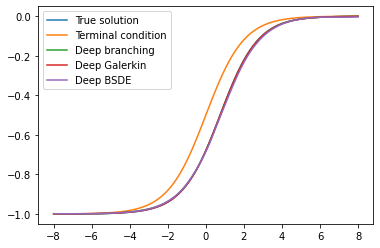

In [6]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

## Exponential nonlinearity
$$
\partial_t u(t,x) + \frac{\alpha}{d} \sum\limits_{i=1}^d \partial_{x_i} u(t,x)
+ \frac{1}{2} \Delta u(t,x)
+ e^{-u(t,x)} ( 1 - 2 e^{-u(t,x)} ) d = 0,
$$
admits the traveling wave solution
$$
u(t,x) = \log \left( 1 + \left( \sum\limits_{i=1}^d x_i + \alpha (T-t)\right)^2 \right),
\qquad (t,x) \in [0,T]\times \mathbb{R}^d.
$$

In [7]:
alpha = 10

# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return torch.exp(-y[0]) - 2 * torch.exp(-2 * y[0]) + alpha * y[1]

dgm_deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return .5 * y[2] + torch.exp(-y[0]) - 2 * torch.exp(-2 * y[0]) + alpha * y[1]

def phi_example(x, coordinate=0):
    return torch.log(1 + x[0] ** 2)

def exact_example(t, x, T):
    return np.log(1 + (x[0] + alpha * (T - t)) ** 2)

t_lo, x_lo, x_hi = 0., -4., 4.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .05
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 38 seconds; L1 error: 1.26E-02; L2 error: 4.71E-04; rel error: 1.33E+00.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 60 seconds; L1 error: 1.31E-02; L2 error: 2.72E-04; rel error: 7.20E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 95 seconds; L1 error: 1.36E-02; L2 error: 4.50E-04; rel error: 1.66E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 37 seconds; L1 error: 1.40E-02; L2 error: 5.20E-04; rel error: 9.45E-01.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 62 seconds; L1 error: 9.59E-03; L2 error: 2.27E-04; rel error: 1.02E+00.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 97 seconds; L1 error: 1.03E-02; L2 error: 2.54E-04; rel error: 

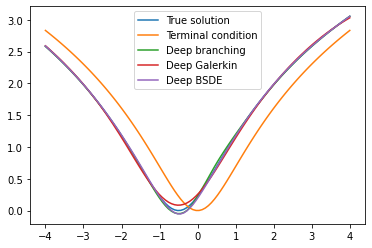

In [8]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="exponential",
                    branch_nb_states=1000, branch_nb_path_per_state=30000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

## Cosine nonlinearity
$$
   \partial_t u(t,x) + \frac{\alpha}{d} \sum\limits_{i=1}^d \partial_{x_i} u(t,x)
   + u(t,x) - \left(\frac{\Delta u(t,x)}{12d} \right)^2
   + \frac{1}{d} \sum\limits_{i=1}^d
        \cos \left( \frac{\pi \partial^4_{x_i} u(t,x)}{4!} \right)
   = 0,
$$
admits the solution
$$
u(t,x)=\varphi \left( \sum\limits_{i=1}^d x_i + \alpha ( T-t)\right),
\qquad (t,x) \in [0,T]\times \mathbb{R}^d,
$$
where
$\varphi (y) := y^4 + y^3 + by^2 + cy + d$ for $y \in \mathbb{R}$,
$b = -\frac{36}{47}$, $c = 24b$, $d = 4b^2$, and $\alpha = 10$.

In [9]:
alpha = 10

# function definition
deriv_map = np.array([0, 1, 2, 4]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> forth deriv
    """
    return -.5 * y[2] + alpha * y[1] + y[0] - (y[2] / 12) ** 2 + torch.cos(math.pi * y[3] / 24)

dgm_deriv_map = np.array([0, 1, 2, 4]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> forth deriv
    """
    return alpha * y[1] + y[0] - (y[2] / 12) ** 2 + torch.cos(math.pi * y[3] / 24)

def phi_example(x, coordinate=0):
    return x[0]**4 + x[0]**3 - 36/47 * x[0]**2 - 24*36/47 * x[0] + 4 * (36/47)**2

def exact_example(t, x, T):
    xx = x[0] + alpha * (T - t)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

t_lo, x_lo, x_hi = 0., -5., 5.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .04
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 35 seconds; L1 error: 9.26E+00; L2 error: 6.99E+02; rel error: 2.06E-01.
fdb runtime: 0 seconds; total runtime: 35 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 170 seconds; L1 error: 1.37E+01; L2 error: 5.98E+02; rel error: 3.30E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 40 seconds; L1 error: 1.07E+01; L2 error: 3.92E+02; rel error: 2.02E-01.
fdb runtime: 0 seconds; total runtime: 41 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 183 seconds; L1 error: 1.14E+02; L2 error: 1.50E+04; rel error: 1.16E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 38 seconds; L1 error: 1.29E+01; L2 error: 6.97E+02; rel error: 2.85E-01.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken:

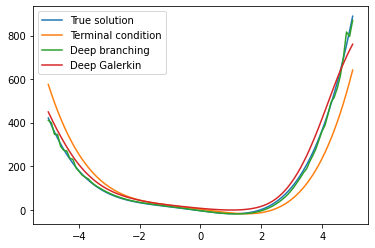

In [10]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[0], 
                    # disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, dgm_lr=1e-2, fname="cosine",
                    branch_nb_states=1000, branch_nb_path_per_state=2500,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

## Log nonlinearity
$$
   \label{eq:example 6}
   \partial_t u(t,x) + \frac{\alpha}{d} \sum\limits_{i=1}^d \partial_{x_i} u(t,x)
   + \log \left(
       \frac{1}{d} \sum\limits_{i=1}^d
       \left(\partial^2_{x_i} u(t,x)\right)^2 + \left(\partial^3_{x_i} u(t,x)\right)^2
   \right)
   = 0,
$$
admits the solution
$$
u(t,x) = \cos \left( \sum\limits_{i=1}^d x_i + \alpha (T-t)\right),
\qquad (t,x) \in [0,T]\times \mathbb{R}^d.
$$

In [11]:
alpha = 10

# function definition
deriv_map = np.array([1, 2, 3]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> first deriv
    idx 1 -> second deriv
    idx 2 -> third deriv
    """
    return -.5 * y[1] + alpha * y[0] + torch.log(y[1]**2 + y[2]**2)

dgm_deriv_map = np.array([1, 2, 3]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> first deriv
    idx 1 -> second deriv
    idx 2 -> third deriv
    """
    return alpha * y[0] + torch.log(y[1]**2 + y[2]**2)

def phi_example(x, coordinate=0):
    return torch.cos(x[0])

def exact_example(t, x, T):
    return np.cos(x[0] + alpha * (T-t))

t_lo, x_lo, x_hi = 0., -3., 3.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .02
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 45 seconds; L1 error: 4.95E-03; L2 error: 3.63E-05; rel error: 2.00E-02.
fdb runtime: 0 seconds; total runtime: 45 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 105 seconds; L1 error: 1.27E-01; L2 error: 2.12E-02; rel error: 4.56E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 45 seconds; L1 error: 4.99E-03; L2 error: 4.26E-05; rel error: 1.26E-02.
fdb runtime: 0 seconds; total runtime: 45 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 107 seconds; L1 error: 6.08E-02; L2 error: 4.83E-03; rel error: 2.57E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 44 seconds; L1 error: 4.38E-03; L2 error: 3.09E-05; rel error: 1.52E-02.
fdb runtime: 0 seconds; total runtime: 44 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken:

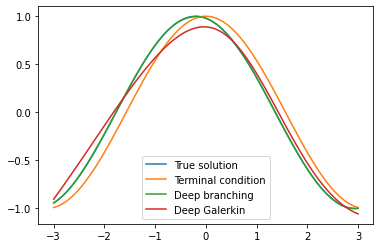

In [12]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[0], 
                    # disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="log",
                    branch_nb_states=1000, branch_nb_path_per_state=6000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    bsde_nb_states=1000, bsde_nb_time_intervals=5,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

## Merton problem
$$
\partial_t u(t, x)
- \frac{(\mu \partial_x u(t, x))^2}{2\sigma^2 \partial^2_x u(t, x)}
+ \frac{\gamma}{1 - \gamma} (\partial_x u(t, x))^{1 - 1/\gamma}
= \rho u(t, x),
$$
admits the solution
$$
u(t, x) =
\frac{x^{1-\gamma} (1 + (\alpha - 1) e^{-\alpha (T-t)})^\gamma}
        {\alpha^\gamma (1 - \gamma)},
\qquad (t,x) \in [0,T]\times \mathbb{R},
$$
where $\alpha := \frac{ 2\sigma^2 \gamma \rho - (1-\gamma)\mu^2}{ 2\sigma^2 \gamma^2}$.

In [13]:
mu = .03
sigma = .1
gamma = .5
rho = .01

# TODO: how to deal with negative x and y[1] properly???

# function definition
deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -.5 * y[2] - (mu * y[1])**2 / (2 * sigma**2 * y[2]) + gamma * y[1].abs()**(1 - 1/gamma) / (1 - gamma) - rho * y[0]

dgm_deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -(mu * y[1])**2 / (2 * sigma**2 * y[2]) + gamma * y[1].abs()**(1 - 1/gamma) / (1 - gamma) - rho * y[0]

def phi_example(x, coordinate=0):
    return x[0].abs() ** (1 - gamma) / (1 - gamma)

def exact_example(t, x, T):
    nu = (2 * sigma**2 * gamma * rho - (1 - gamma) * mu**2) / (2 * sigma**2 * gamma**2)
    return x[0]**(1 - gamma) * (1 + (nu-1) * math.exp(-nu * (T - t)))**gamma / (nu**gamma * (1 - gamma))

t_lo, x_lo, x_hi = 0., 100., 200.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .1
true = exact_example(t_lo, grid_d_dim, T).real
terminal = exact_example(T, grid_d_dim, T).real

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 48 seconds; L1 error: 6.99E-03; L2 error: 7.32E-05; rel error: 2.70E-04.
fdb runtime: 0 seconds; total runtime: 48 seconds.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 175 seconds; L1 error: 1.69E+00; L2 error: 2.89E+00; rel error: 6.66E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 47 seconds; L1 error: 4.83E-03; L2 error: 4.20E-05; rel error: 1.95E-04.
fdb runtime: 0 seconds; total runtime: 47 seconds.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 173 seconds; L1 error: 1.52E+00; L2 error: 2.38E+00; rel error: 5.90E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 45 seconds; L1 error: 6.30E-03; L2 error: 5.50E-05; rel error: 2.40E-04.
fdb runtime: 0 seconds; total runtime: 45 seconds.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 177 seconds

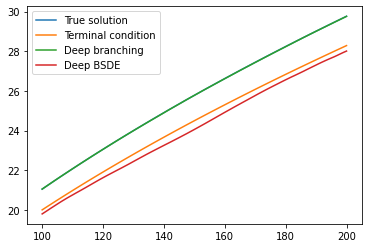

In [14]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="merton",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4, y_lo=0, y_hi=100,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

## Non-Newtonian burgers equation

$$
\partial_t u(t, x)
+ \frac{\nu}{2} 
\partial_x \left( |\partial_x u(t, x)|^{n - 1} \partial_x u(t, x) \right)
- u \partial_x u(t, x)
= 0,
$$
admits the solution
$$
u(t, x) =
f^{-1}(\xi),
\qquad (t,x) \in [0,T]\times \mathbb{R},
$$
where $\xi := x - \frac{u_1+u_2}{2}(T-t)$
and
$$
f(u)
= (2 \nu)^{1/n} \int \frac{((u - u_1)(u_2 - u))^{1 - 1/n}}{(u - u_1)(u - u_2)} du.
$$

The PDE solution $u$ satisfies the property that
$$
\lim\limits_{x \to -\infty} u(t, x) = u_2,
\quad
\lim\limits_{x \to \infty} u(t, x) = u_1,
\quad
\lim\limits_{|x| \to \infty} \partial_x u(t, x) = 0,
$$
where $u_2 > u_1$.

We note that since
the inverse function of $f$ may not be available in closed-form,
we use the library `pynverse`
to obtain pointwise samples of the inverse function.
Then, we use neural nertwork written in PyTorch
to learn the pointwise samples
so that we have the full knowledge of the derivatives of $\phi$
to be used by the deep branching solver.

In [15]:
def gen_fun_and_inv(n, eps, nu, u1, u2):
    if n <= 1/4 and (1/n) % 1 == 0:
        print("Infinity detected when calculating hypergeometric function, the calculation is not accurate!")
    if n == 1:
        fun = (
            lambda u:(
                nu/(u2-u1)*np.log((u2 - u)/(u - u1))
            )
        )
    elif n == 1/2:
        fun = (
            lambda u: (
                nu**2*(
                    (u2-u1)**(-2)*(1/(u-u1) - 1/(u2-u))
                    + 2*(u2-u1)**(-3)*np.log((u2-u)/(u-u1)))
            )
        )
    elif n == 1/3:
        fun = (
            lambda u: (
                nu**3*(
                    .5*(u2-u1)**(-3)*(1/(u-u1)**2 - 1/(u2-u)**2)
                    + 3*(u2-u1)**(-4)*(1/(u-u1) - 1/(u2-u))
                    + 6*(u2-u1)**(-5)*np.log((u2-u)/(u-u1)))
            )
        )
    else:
        fun = (lambda u:-nu**(1/n)*n*(u-u1)*((u2-u1)*(u-u1))**(-1/n)*special.hyp2f1(1/n,1-1/n,2-1/n, (u-u1)/(u2-u1))/(n-1))
    inv = (lambda xi: inversefunc(fun, y_values=xi, domain=[u1+eps,u2-eps]))
    return fun, inv


def gen_for_generalized_burgers(
    n=1,
    T=1.,
    u1=0.,
    u2=1.,
    nu=1,
    eps=1e-6,
    eps_graph=1e-2,
    verbose=False
):
    neurons = 50
    nb_points = 10000
    lambd = (u1 + u2) / 2
    require_training = not(n == 1 or n == 2)
    fun, inv = gen_fun_and_inv(n=n, eps=eps, nu=nu, u1=u1, u2=u2)
    
    if require_training:
        torch.manual_seed(0)
        # neural network parameter
        inv_model = torch.nn.Sequential(
            torch.nn.BatchNorm1d(1, device=device),
            torch.nn.Linear(1, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, 1, device=device),
        )

        # define the functions, x, and y
        x_for_fun = np.linspace(u1, u2, nb_points + 2)[1:-1]
        x_lo, x_hi = fun(u2-eps), fun(u1+eps)
        x = np.linspace(x_lo, x_hi, nb_points)
        y = torch.tensor(inv(x), dtype=torch.get_default_dtype(), device=device)
        x = torch.tensor(x, dtype=torch.get_default_dtype(), device=device).unsqueeze(dim=-1)

        # neural network training
        optimizer = torch.optim.Adam(inv_model.parameters(), lr=1e-2)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2000, 4000, 6000, 8000], gamma=0.5)
        loss_fun = torch.nn.MSELoss()
        inv_model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            loss = loss_fun(y, inv_model(x).squeeze())
            loss.backward()
            optimizer.step()
            scheduler.step()
            if epoch % 100 == 0 and verbose:
                print(f"Epoch {epoch}, loss = {loss}")
        inv_model.eval()

        # detach all model parameters to save memory
        for p in inv_model.parameters():
            p.requires_grad = False

        if verbose:
            # plot the graph
            plt.plot(x.cpu(), inv_model(x).detach().cpu(), label="NN approximation")
            plt.plot(x.cpu(), y.cpu(), label="true inverse")
            plt.legend()
            plt.show()
            print(f"The max difference is {(y.cpu() - inv_model(x).detach().cpu().squeeze()).abs().max()}.")

    # function definition
    deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
    def f_example(y, coordinate=0):
        """
        idx 0 -> no deriv
        idx 1 -> first deriv
        idx 2 -> second deriv
        """
        return (
            - y[0] * y[1]
            + nu * y[2] * n * y[1].abs()**(n-1) / 2
            - nu * y[2] / 2
        )

    def phi_example(x, coordinate=0):
        if n == 1:
            return u2 + (u1 - u2) / (1 + torch.exp((u1 - u2) * x[0] / nu))
        elif n == 2:
            return u1 + (u2 - u1) * torch.sin(-x[0] / (2 * math.sqrt(nu)))**2
        else:
            return inv_model(x.T).squeeze(dim=-1)

    def exact_example(t, x, T):
        xi = x[0] - lambd * (T - t)
        if n == 1:
            return u2 + (u1 - u2) / (1 + np.exp((u1 - u2) * xi / nu))
        elif n == 2:
            return u1 + (u2 - u1) * np.sin(-xi / (2 * math.sqrt(nu)))**2
        else:
            return inv(xi)

    t_lo, x_lo, x_hi = 0., -10., 10.
    # best view for waterfall, eps < eps_graph
    x_lo, x_hi = fun(u2-eps_graph) + lambd * T, fun(u1+eps_graph)
    grid = np.linspace(x_lo, x_hi, 100)
    grid_d_dim = np.expand_dims(grid, axis=0)
    grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

    true = exact_example(t_lo, grid_d_dim, T)
    terminal = exact_example(T, grid_d_dim, T)
    return grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, f_example, deriv_map, phi_example

### n = 1, T = .5
$$
f(u)
= \frac{2 \nu}{u_2 - u_1} \log\left( \frac{u_2-u}{u-u_1} \right),
$$
see e.g.
[wolfram alpha](https://www.wolframalpha.com/input?i=int%5B%28%28u-u1%29*%28u2-u%29%29%5E%281-1%29%2F%28%28u-u1%29*%28u-u2%29%29%2Cu%5D%2C).

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 36 seconds; L1 error: 1.14E-03; L2 error: 2.76E-06; rel error: 7.21E-03.
fdb runtime: 0 seconds; total runtime: 36 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 35 seconds; L1 error: 1.23E-03; L2 error: 2.92E-06; rel error: 7.02E-03.
fdb runtime: 0 seconds; total runtime: 35 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 36 seconds; L1 error: 8.98E-04; L2 error: 1.69E-06; rel error: 5.19E-03.
fdb runtime: 0 seconds; total runtime: 36 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 34 seconds; L1 error: 9.08E-04; L2 error: 1.46E-06; rel error: 6.24E-03.
fdb runtime: 0 seconds; total runtime: 34 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 34 seconds; L1 error: 1.18E-03; L2 error: 2.62E-06; rel error: 1.02E-02.
fdb runtime: 0 seconds;

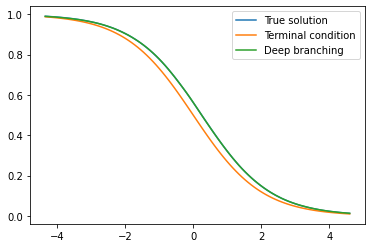

In [16]:
n, T = 1, .5
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_bsde=True, disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname=f"burger_{n}",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

### n = 2, T = .2
Since $\frac{1}{n}$ is not integer,
$$
-\frac{n(2 \nu)^{1/n}}{n-1} (u - u_1) ((u_2 - u_1)(u - u_1))^{-1/n}
{}_2F_1 \left(\frac{1}{n}, 1-\frac{1}{n}, 2-\frac{1}{n}; \frac{u_1 - u}{u_1 - u_2}\right),
$$
see e.g.
[wolfram alpha](https://www.wolframalpha.com/input?i=int%5B%28%28u-u1%29*%28u2-u%29%29%5E%281-1%2Fn%29%2F%28%28u-u1%29*%28u-u2%29%29%2Cu%5D).

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 36 seconds; L1 error: 2.92E-03; L2 error: 1.26E-05; rel error: 2.10E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 36 seconds; L1 error: 2.07E-03; L2 error: 8.53E-06; rel error: 1.54E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 37 seconds; L1 error: 2.48E-03; L2 error: 1.16E-05; rel error: 1.82E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 38 seconds; L1 error: 2.74E-03; L2 error: 1.41E-05; rel error: 2.34E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 37 seconds; L1 error: 2.30E-03; L2 error: 9.65E-06; rel error: 1.61E-02.
fdb runtime: 0 seconds;

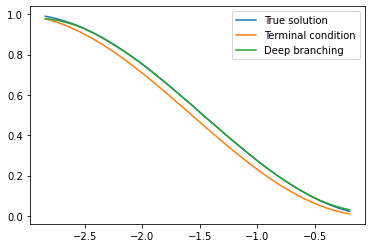

In [17]:
n, T = 2, .2
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_bsde=True, disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname=f"burger_{n}",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

### n = 1/2, T = 2
$$
f(u)
= (2 \nu)^2
\left(
(u_2 - u_1)^{-2} \left(\frac{1}{u-u_1} - \frac{1}{u_2-u}\right)
+ 2 (u_2 - u_1)^{-3} \log\left(\frac{u_2 - u}{u - u_1}\right)
\right),
$$
see e.g.
[wolfram alpha](https://www.wolframalpha.com/input?i=int%5B%28%28u-u1%29*%28u2-u%29%29%5E%281-2%29%2F%28%28u-u1%29*%28u-u2%29%29%2Cu%5D%2C).

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 49 seconds; L1 error: 8.42E-04; L2 error: 1.21E-06; rel error: 2.55E-03.
fdb runtime: 0 seconds; total runtime: 49 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 48 seconds; L1 error: 1.10E-03; L2 error: 2.62E-06; rel error: 2.64E-03.
fdb runtime: 0 seconds; total runtime: 48 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 49 seconds; L1 error: 1.49E-03; L2 error: 4.45E-06; rel error: 3.22E-03.
fdb runtime: 0 seconds; total runtime: 50 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 48 seconds; L1 error: 9.59E-04; L2 error: 1.84E-06; rel error: 2.40E-03.
fdb runtime: 0 seconds; total runtime: 48 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 48 seconds; L1 error: 1.03E-03; L2 error: 1.90E-06; rel error: 2.37E-03.
fdb runtime: 0 seconds;

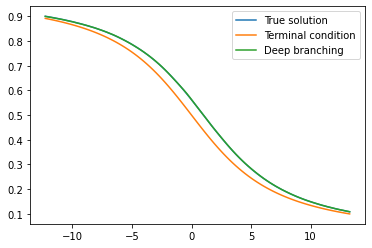

In [18]:
n, T = 1/2, 2.
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=n, T=T, eps=1e-3, eps_graph=1e-1)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_bsde=True, disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname=f"burger_{n}",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

### n = 3, T = .1
Since $\frac{1}{n}$ is not integer,
$$
-\frac{n(2 \nu)^{1/n}}{n-1} (u - u_1) ((u_2 - u_1)(u - u_1))^{-1/n}
{}_2F_1 \left(\frac{1}{n}, 1-\frac{1}{n}, 2-\frac{1}{n}; \frac{u_1 - u}{u_1 - u_2}\right),
$$
see e.g.
[wolfram alpha](https://www.wolframalpha.com/input?i=int%5B%28%28u-u1%29*%28u2-u%29%29%5E%281-1%2Fn%29%2F%28%28u-u1%29*%28u-u2%29%29%2Cu%5D).

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 50 seconds; L1 error: 2.18E-03; L2 error: 9.42E-06; rel error: 1.35E-02.
fdb runtime: 0 seconds; total runtime: 50 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 48 seconds; L1 error: 3.53E-03; L2 error: 2.93E-05; rel error: 1.52E-02.
fdb runtime: 0 seconds; total runtime: 48 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 48 seconds; L1 error: 4.07E-03; L2 error: 2.16E-05; rel error: 2.05E-02.
fdb runtime: 0 seconds; total runtime: 48 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 47 seconds; L1 error: 3.22E-03; L2 error: 1.58E-05; rel error: 1.36E-02.
fdb runtime: 0 seconds; total runtime: 47 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 48 seconds; L1 error: 3.59E-03; L2 error: 1.81E-05; rel error: 2.21E-02.
fdb runtime: 0 seconds;

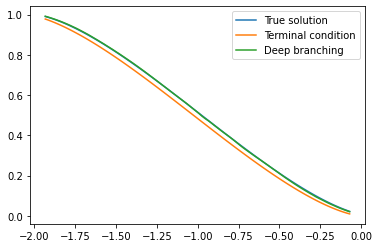

In [19]:
n, T = 3, .1
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_bsde=True, disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname=f"burger_{n}",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

### n = 1/3, T = 10
$$
f(u)
= (2 \nu)^3
\left(
\frac{(u_2 - u_1)^{-3}}{2} \left(\frac{1}{(u-u_1)^2} - \frac{1}{(u_2-u)^2}\right)
+ 3 (u_2 - u_1)^{-4} \left(\frac{1}{u-u_1} - \frac{1}{u_2-u}\right)
+ 6 (u_2 - u_1)^{-5} \log\left(\frac{u_2 - u}{u - u_1}\right)
\right),
$$
see e.g.
[wolfram alpha](https://www.wolframalpha.com/input?i=int%5B%28%28u-u1%29*%28u2-u%29%29%5E%281-3%29%2F%28%28u-u1%29*%28u-u2%29%29%2Cu%5D%2C).

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 50 seconds; L1 error: 1.89E-03; L2 error: 9.21E-06; rel error: 4.40E-03.
fdb runtime: 0 seconds; total runtime: 50 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 52 seconds; L1 error: 1.76E-03; L2 error: 9.19E-06; rel error: 4.28E-03.
fdb runtime: 0 seconds; total runtime: 52 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 50 seconds; L1 error: 1.88E-03; L2 error: 1.02E-05; rel error: 4.51E-03.
fdb runtime: 0 seconds; total runtime: 50 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 51 seconds; L1 error: 1.65E-03; L2 error: 5.63E-06; rel error: 3.88E-03.
fdb runtime: 0 seconds; total runtime: 51 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 51 seconds; L1 error: 1.65E-03; L2 error: 5.23E-06; rel error: 4.78E-03.
fdb runtime: 0 seconds;

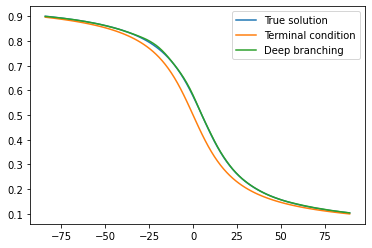

In [20]:
n, T = 1/3, 10.
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=n, T=T, eps=1e-2, eps_graph=1e-1)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_bsde=True, disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname=f"burger_{n}",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

# 5-dimensional PDE
In this section,
we test deep branching solver
with the examples above
in the case of $d_{in} = 5$.

## Allen-Cahn

In [5]:
fixed_dim, dim = 0, 5

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0      -> no deriv
    idx 1 to n -> second deriv
    """
    return .5 * y[1:].sum(axis=0) + y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

t_lo, x_lo, x_hi = 0., -8., 8.
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 92 seconds; L1 error: 3.61E-03; L2 error: 2.06E-05; rel error: 6.54E-03.
fdb runtime: 0 seconds; total runtime: 92 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 156 seconds; L1 error: 5.94E-03; L2 error: 3.78E-05; rel error: 2.43E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 108 seconds; L1 error: 3.75E-03; L2 error: 2.07E-05; rel error: 1.09E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 89 seconds; L1 error: 3.71E-03; L2 error: 2.12E-05; rel error: 6.77E-03.
fdb runtime: 0 seconds; total runtime: 89 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 161 seconds; L1 error: 3.30E-03; L2 error: 2.38E-05; rel error: 2.30E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 105 seconds; L1 error: 4.45E-03; L2 error: 2.83E-05; rel err

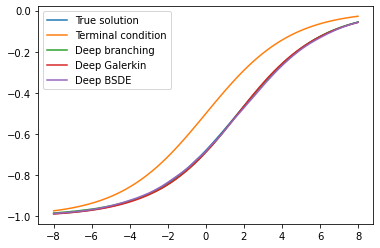

In [6]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=100,
                    bsde_nb_states=100000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

## Exponential nonlinearity

In [7]:
fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0      -> no deriv
    idx 1 to d -> first deriv
    """
    return alpha/dim*y[1:].sum(dim=0) - 2*dim*torch.exp(-2*y[0]) + dim*torch.exp(-y[0])

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0         -> no deriv
    idx 1 to d    -> first deriv
    idx 1+d to 2d -> second deriv
    """
    return .5 * y[(dim+1):].sum(dim=0) + alpha/dim*y[1:(dim+1)].sum(dim=0) - 2*dim*torch.exp(-2*y[0]) + dim*torch.exp(-y[0])

def phi_example(x, coordinate=0):
    return torch.log(1 + x.sum(dim=0) ** 2)

def exact_example(t, x, T):
    return np.log(1 + (x.sum(axis=0) + alpha * (T - t)) ** 2)

t_lo, x_lo, x_hi = 0., -4., 4.
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .05
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 54 seconds; L1 error: 2.28E-02; L2 error: 2.24E-03; rel error: 9.93E-01.
fdb runtime: 0 seconds; total runtime: 55 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 212 seconds; L1 error: 2.36E+00; L2 error: 6.97E+00; rel error: 9.18E+01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 109 seconds; L1 error: 1.89E-02; L2 error: 1.55E-03; rel error: 3.33E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 54 seconds; L1 error: 3.82E-02; L2 error: 6.72E-03; rel error: 4.27E+00.
fdb runtime: 0 seconds; total runtime: 54 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 228 seconds; L1 error: 1.88E+00; L2 error: 4.98E+00; rel error: 8.29E+01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 114 seconds; L1 error: 1.92E-02; L2 error: 1.37E-03; rel err

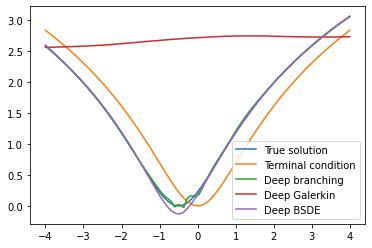

In [8]:
# corrected bn_layer for deep_bsde method
#
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_galerkin=True, disable_bsde=True, disable_branch=True,
                    T=T, device=device, epochs=3000, fname="exponential",
                    branch_nb_states=1000, branch_nb_path_per_state=3000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=100,
                    bsde_nb_states=100000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

## Cosine nonlinearity

In [9]:
fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim), 4 * np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0          -> no deriv
    idx 1 to d     -> first deriv
    idx 1+d to 2d  -> second deriv
    idx 1+2d to 3d -> forth deriv
    """
    return -.5 * y[(dim+1):(2*dim+1)].sum(dim=0) + alpha * y[1:(dim+1)].sum(dim=0) / dim + y[0] - (y[(dim+1):(2*dim+1)].sum(dim=0) / 12 / dim) ** 2 + torch.cos(math.pi * y[(2*dim+1):] / 24).sum(dim=0) / dim
    

dgm_deriv_map = deriv_map
def dgm_f_example(y):
    """
    idx 0          -> no deriv
    idx 1 to d     -> first deriv
    idx 1+d to 2d  -> second deriv
    idx 1+2d to 3d -> forth deriv
    """
    return alpha * y[1:(dim+1)].sum(dim=0) / dim + y[0] - (y[(dim+1):(2*dim+1)].sum(dim=0) / 12 / dim) ** 2 + torch.cos(math.pi * y[(2*dim+1):] / 24).sum(dim=0) / dim

def phi_example(x, coordinate=0):
    xx = x.sum(dim=0)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

def exact_example(t, x, T):
    xx = x.sum(axis=0) + alpha * (T - t)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

t_lo, x_lo, x_hi = 0., -5., 5.
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .04
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 91 seconds; L1 error: 1.15E+01; L2 error: 3.80E+02; rel error: 1.78E-01.
fdb runtime: 180 seconds; total runtime: 271 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 794 seconds; L1 error: 2.59E+02; L2 error: 7.88E+04; rel error: 3.10E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 66 seconds; L1 error: 1.19E+01; L2 error: 4.90E+02; rel error: 2.12E-01.
fdb runtime: 92 seconds; total runtime: 158 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 799 seconds; L1 error: 2.57E+02; L2 error: 7.77E+04; rel error: 3.08E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 46 seconds; L1 error: 1.23E+01; L2 error: 5.47E+02; rel error: 2.46E-01.
fdb runtime: 25 seconds; total runtime: 71 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time 

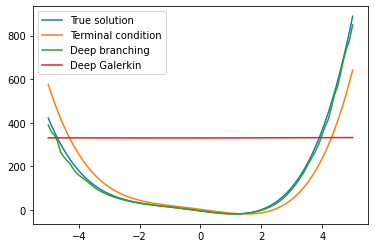

In [10]:
 # Performance comparison
 #
 # choosing one percentile for removal of outlier in the case of branch_nb_path_per_state=50
 # does not completely remove any outlier
 # we have to choose three percentile in this case
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[0],
                    # disable_galerkin=True, verbose=True, debug_mode=True, disable_branch=True,
                    T=T, device=device, epochs=3000, fname="cosine",
                    branch_nb_states=1000, branch_nb_path_per_state=50,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200, outlier_percentile=3,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

## Log nonlinearity

In [11]:
fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((1 * np.identity(dim), 2 * np.identity(dim), 3 * np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0 to d-1   -> first deriv
    idx d to 2d-1  -> second deriv
    idx 2d to 3d-1 -> third deriv
    """
    return -.5 * y[dim:(2*dim)].sum(dim=0) + alpha * y[:dim].sum(dim=0) / dim + torch.log(((y[dim:(2*dim)]**2).sum(dim=0) + (y[(2*dim):]**2).sum(dim=0)) / dim)
    

dgm_deriv_map = deriv_map
def dgm_f_example(y):
    """
    idx 0 to d-1   -> first deriv
    idx d to 2d-1  -> second deriv
    idx 2d to 3d-1 -> third deriv
    """
    return alpha * y[:dim].sum(dim=0) / dim + torch.log(((y[dim:(2*dim)]**2).sum(dim=0) + (y[(2*dim):]**2).sum(dim=0)) / dim)

def phi_example(x, coordinate=0):
    return torch.cos(x.sum(dim=0))

def exact_example(t, x, T):
    return np.cos(x.sum(axis=0) + alpha * (T-t))

t_lo, x_lo, x_hi = 0., -3., 3.
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .02
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 70 seconds; L1 error: 1.47E-02; L2 error: 3.24E-04; rel error: 4.89E-02.
fdb runtime: 115 seconds; total runtime: 185 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 480 seconds; L1 error: 6.41E-01; L2 error: 5.22E-01; rel error: 1.32E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 43 seconds; L1 error: 2.88E-02; L2 error: 2.91E-03; rel error: 7.66E-02.
fdb runtime: 29 seconds; total runtime: 72 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 445 seconds; L1 error: 6.40E-01; L2 error: 5.22E-01; rel error: 1.36E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 41 seconds; L1 error: 3.48E-02; L2 error: 2.50E-03; rel error: 2.03E-01.
fdb runtime: 32 seconds; total runtime: 73 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time t

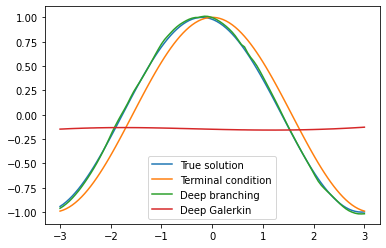

In [12]:
# Performance comparison
#
# choosing one percentile for removal of outlier in the case of branch_nb_path_per_state=50
# does not completely remove any outlier
# we have to choose five percentile in this case
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[7],
                    # disable_galerkin=True, verbose=True, debug_mode=True, disable_branch=True,
                    T=T, device=device, epochs=3000, fname="log",
                    branch_nb_states=1000, branch_nb_path_per_state=200,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200, outlier_percentile=5,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)